# Force Optimizations Data Analysis 

*As a note, time-intensive code that has been run in advance has been commented out.*

In [1]:
from analysis_tools import *
from desc.plotting import plot_boozer_surface
from optimization_tools import *
import imageio
import matplotlib
import matplotlib.pyplot as plt
import os

DESC version 0.11.1,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 15.02 GB available memory


## Ensemble of Optimizations

### Initial Optimizations
First, we perform our initial optimizations using the random (educated) guesses for the weights on the objective function. As these optimizations demand significant computational resources, the code is commented out for the purpose of this example. 

In [ ]:
# initial_optimizations()

We next analyze our set of optimizations and parse the data into three DataFrames: `df`, representing the full set of optimizations; `df_filtered`, representing the set of optimizations that passed pre-specified filtering criteria; and `df_pareto1`, representing the set of optimizations on the Pareto front. (This method also exports the Universally Unique Identifiers (unique identifiers for each optimization) of the Pareto front to 
`pareto.txt`). 

In [ ]:
df, df_filtered, df_pareto = get_dfs()

Let's take a look at our optimizations!

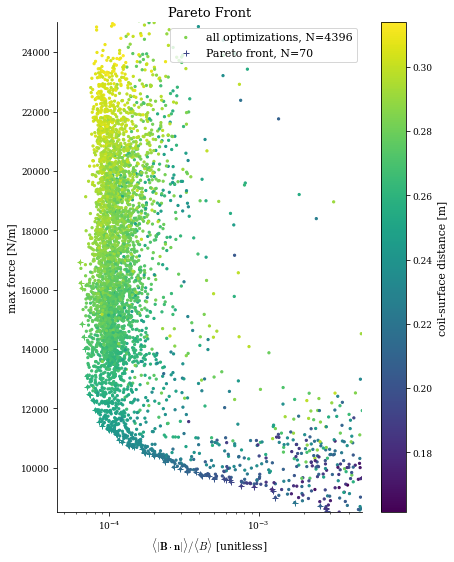

In [ ]:
fig = plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
markersize = 5
n_pareto = df_pareto.shape[0]
n_filtered = df_filtered.shape[0] - n_pareto
color="coil_surface_distance"
color_label="coil-surface distance [m]"
norm = plt.Normalize(min(df_filtered[color]), max(df_filtered[color]))
plt.scatter(
    df_filtered["normalized_BdotN"],
    df_filtered["max_max_force"],
    c=df_filtered[color],
    s=markersize,
    label=f'all optimizations, N={n_filtered}',
    norm=norm
)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    c=df_pareto[color], 
    marker="+",
    label=f'Pareto front, N={n_pareto}',
    norm=norm,
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered["normalized_BdotN"]), max(df_filtered["normalized_BdotN"]))
plt.ylim(8500, 25000)
plt.xscale("log")
plt.colorbar(label=color_label)
plt.legend(loc='upper right', fontsize='11')
plt.title('Pareto Front')
plt.show()

### Continuation Method
Now, let us perform the first iteration of our continuation method. Here, we perform the first iteration and allow the maximum variation in any parameter to be a randomly chosen number in the range $10^{-3}$ to $5\times 10^{-2}$. From this point, it is possible to perform the $i+1$-th iteration of the continuation method by using the $i$-th Pareto fronts as input.

In [ ]:
# for i in range(1000): continuation(N=1, dx = 10**rand(-3, -1.3))

If desired, we can also export the Pareto fronts unique folders for easy access. This is helpful for high-performance computing calculations, in which one wishes to reduce the number of files stored on the system.

In [ ]:
# for folder in os.listdir("./output/QA/"):
#     f = os.path.join("./output/QA/", folder)
#     if not os.path.isfile(f)
#         get_dfs(INPUT_DIR = f"{f}/optimizations/", OUTPUT_DIR=f"{f}/pareto/")

Now, let us see how performing the continuation method impacts our Pareto fronts. 

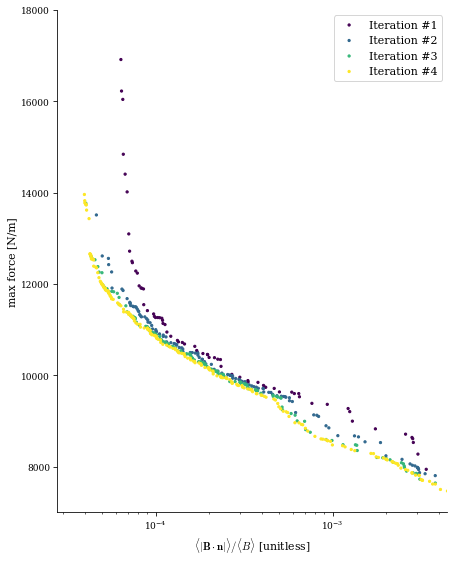

In [ ]:
fig = plt.figure(figsize=(6.5, 8))
norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/", f)) for f in os.listdir("./output/QA/")))
plt.rc("font", size=13)
for filename in sorted(os.listdir("./output/QA/")):
    f = os.path.join("./output/QA/", filename)
    if os.path.isdir(f):
        *_, df = get_dfs(INPUT_DIR = f + "/optimizations/")
        plt.scatter(
            df["normalized_BdotN"],
            df["max_max_force"],
            s=5,
            c=int(filename)*np.ones(len(df["UUID"])),
            label=f"Iteration #{filename}",
            norm=norm
        )
        
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
plt.ylim(7000, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()

It is also helpful to obtain DataFrames of our final Pareto front.

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')

Here, we create an interactive plot of the Pareto front. This is particularly useful for identifying specific optimizations visually based on their UUID. 

In [ ]:
pareto_interactive_plt(df_pareto_final).show()

An interesting thing to analyze are the Pearson's R correlations between the maximum force on a coil and other optimization parameters. Interestingly, we see that the strongest correlation by far is with the coil-surface distance. 

In [ ]:
print(parameter_correlations(df_filtered_final, sort_by="max_max_force").to_markdown())

|    | Parameter             |           R |            P |
|---:|:----------------------|------------:|-------------:|
| 16 | max_max_force         |  1          | 0            |
| 11 | force_threshold       |  0.998699   | 0            |
| 19 | coil_surface_distance |  0.949217   | 0            |
|  1 | length_target         |  0.332135   | 3.49816e-41  |
| 18 | coil_coil_distance    |  0.323327   | 5.33236e-39  |
|  2 | length_weight         |  0.154985   | 8.78901e-10  |
|  9 | cs_threshold          |  0.142949   | 1.61589e-08  |
|  4 | max_κ_weight          |  0.131633   | 2.01999e-07  |
|  7 | cc_threshold          |  0.0143851  | 0.5717       |
|  8 | cc_weight             |  0.00978367 | 0.700509     |
| 20 | dx                    |  0.00370564 | 0.884174     |
| 13 | max_length            | -0.0132361  | 0.602806     |
|  6 | msc_weight            | -0.0245908  | 0.333604     |
| 10 | cs_weight             | -0.0328663  | 0.196212     |
|  3 | max_κ_threshold       | -0.154407

### Plotting the Coils
*In the following examples, we will use the UUIDs* 6266c8d4bb25499b899d86e9e3dd2ee2 *and* c3c984ea02624607b8a59a9fdf0642dd *as examples in order to showcase various plots. The former UUID represents the optimum furthest left on the Pareto front, while the latter UUID represents one on the mid-right of the front.*

Let's save various 2D plots for each of the coils along the Pareto front!

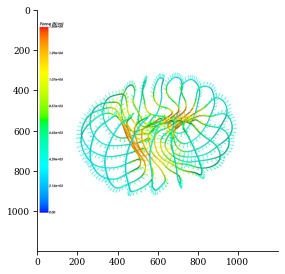

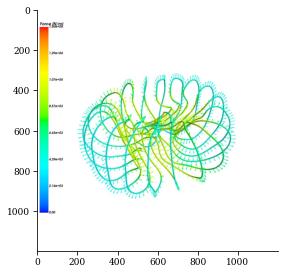

In [ ]:
# fig = mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,1200))
# mlab.options.offscreen = True

# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     path = IN_PATH + UUID + "/"
#     for arrow in [None, "mutual", "self", "force"]:
#         arr = plot_coils(path + "biot_savart.json", fig=fig, arrow=arrow)
#         mlab.clf()
#         if arrow is None:
#             plt.imsave(path + f"coilplot.jpeg", arr)
#         else:
#             plt.imsave(path + f"coilplot_{arrow}.jpeg", arr)

UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/coilplot_force.jpeg")
    plt.figure()
    imgplot = plt.imshow(img)

We can also view these as interactive 3D plots:

In [ ]:
UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    path = "./output/QA/4/optimizations/" + UUID + "/biot_savart.json"
    plot_coils(path, arrow="mutual")
    mlab.show()

Next, let's generate some rotating 3D plots of the coils.

In [ ]:
# fig = mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,1200))
# mlab.options.offscreen = True

# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     plot_coils(IN_PATH + UUID + "/biot_savart.json", fig=fig, arrow="force")

#     nframes = 160
#     filenames = []
#     # For some reason, the first frame is darker, so repeat that frame at the end.
#     for j in range(nframes + 1):
#         mlab.view(azimuth=360.0 * j / nframes, elevation=-52.5 + 7.5 * np.sin(j / nframes * 2 * np.pi), distance=14.00, focalpoint=[0, 0, 0])
#         filename = f'temp{j:04}.png'
#         mlab.savefig(filename=filename)
#         filenames.append(filename)

#     import imageio
#     # Duration is the number of seconds each frame is shown
#     duration = 0.04
#     name = IN_PATH + UUID + "/rotating.gif" 
#     with imageio.get_writer(name, mode='I', duration=duration, loop=0) as writer:
#         for filename in filenames[1:]:
#             image = imageio.imread(filename)
#             writer.append_data(image)
#     mlab.clf()
#     print(f"Wrote {UUID}")

# # Delete the temp files
# temps = glob.glob(f"./**/temp*.png", recursive=True) 
# for temp in temps: os.remove(temp)

![SegmentLocal](./output/QA/4/pareto/6266c8d4bb25499b899d86e9e3dd2ee2/rotating.gif "segment")
![SegmentLocal](./output/QA/4/pareto/c3c984ea02624607b8a59a9fdf0642dd/rotating.gif "segment")

Finally, we can animate the coils as we move in parameter space along the Pareto front! 

In [ ]:
# sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
# images = []
# for UUID in sorted_pareto['UUID']:
#     path = "./output/QA/4/pareto/" + UUID + "/coilplot.jpeg"    
#     images.append(imageio.imread(path))
# create_movies(images, "pareto_coils", "./output/QA/4/")

![SegmentLocal](./output/QA/4/pareto_coils.gif "segment")

To aid in the visualization, let's also create an animation showing the speed at which we move down the Pareto front.

In [ ]:
# fig = plt.figure(figsize=(6.5, 8))
# ax = plt.gca()
# plt.rc("font", size=13)

# *_, df = get_dfs(INPUT_DIR = "./output/QA/4/optimizations/")
# plt.scatter(
#     df["normalized_BdotN"],
#     df["max_max_force"],
#     s=5,
#     c='k'
# )
        
# plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
# plt.ylabel("max force [N/m]")
# plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
# plt.ylim(7000, 14000)
# plt.xscale("log")

# df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')
# sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
# images=[]
# for UUID in sorted_pareto['UUID']:
#     path = "./output/QA/4/optimizations/" + UUID + "/coilplot.jpg"

#     x = float(sorted_pareto.loc[sorted_pareto['UUID'] == UUID]['normalized_BdotN'])
#     y = float(sorted_pareto.loc[sorted_pareto['UUID'] == UUID]['max_max_force'])
#     center = np.array([x,y])
#     dx = np.abs(np.e ** (np.log(x) + 0.14) - x)
#     dy = 150
#     delta = np.array([dx, dy])
#     orig = center - delta / 2

#     rect = matplotlib.patches.Rectangle((orig[0], orig[1]), delta[0], delta[1], fill=False, linewidth=2,color="r")
#     ax.add_patch(rect)

#     fig.canvas.draw()
#     buf = fig.canvas.tostring_rgb()
#     ncols, nrows = fig.canvas.get_width_height()
#     image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
#     images.append(image)

#     rect.remove()
    
# create_movies(images, "pareto", "./output/QA/4/")

![SegmentLocal](./output/QA/4/pareto.mp4 "segment")

## Magnetic Field Analysis


### Computing Equilibria

Let's compute and save the equilibria for all configurations on the Pareto front as this is the most time-intentive task.

In [ ]:
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     if not "eq.h5" in os.listdir(f"./output/QA/4/pareto/{UUID}/"):
#         qfm_surf, _, _ = qfm(UUID)
#         desc_eq = surf_to_desc(qfm_surf)
#         desc_eq.save(IN_PATH + UUID + "/eq.h5")
#         print(f"Saved {UUID}")

### Quasisymmetry measures

#### $|\textbf{B}|$ in Boozer coordinates

Let's export $|\textbf{B}|$ plots for each coil set in the final Pareto front.

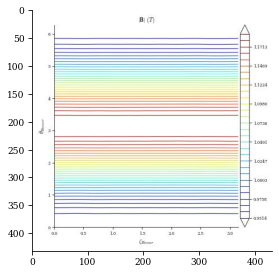

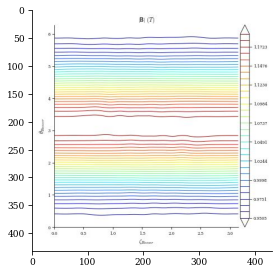

In [ ]:
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     IN_PATH = f"./output/QA/4/pareto/{UUID}/eq.h5"
#     eq = desc.io.load(IN_PATH)
#     fig, ax = plot_boozer_surface(eq)
#     SOURCE_DIR = glob.glob(f"./**/{UUID}/", recursive=True)[0] 
#     EXPORT_PATH = SOURCE_DIR + "B.jpg"
#     plt.savefig(EXPORT_PATH)
#     plt.close()
#     print(f"Exported UUID {UUID}")

UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/B.jpg")
    plt.figure()
    imgplot = plt.imshow(img)

Now, let's create a `.gif` of all the |B| plots!

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')
sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
images = []
for UUID in sorted_pareto['UUID']:
    path = "./output/QA/4/pareto/" + UUID + "/B.jpg"    
    images.append(imageio.imread(path))
create_movies(images, "pareto_B", "./output/QA/4/")

![SegmentLocal](./output/QA/4/pareto_B.gif "segment")

By comparison, here's the target equilibrium!

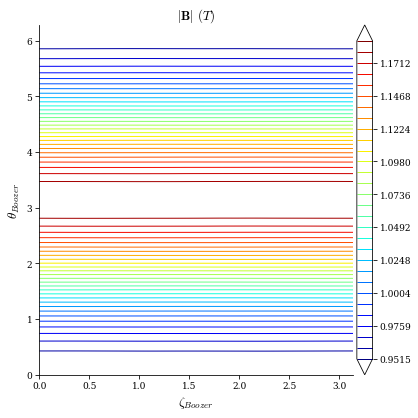

In [ ]:
target_eq = desc.io.load("./inputs/LandremanPaul2021_QA.h5")
fig, ax = plot_boozer_surface(target_eq)
plt.show()

#### Quasisymmetry metrics

Here, the solid lines represent the target equilibrium, while the dashed ones represent the stage-II equilibrium. The three metrics shown are (1) the two-term error function $f_C$ defined on the LCFS, the triple product objective $f_T$ defined throughout the volume, and (3) the Boozer objective $f_B$. 

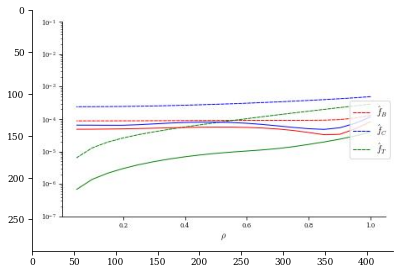

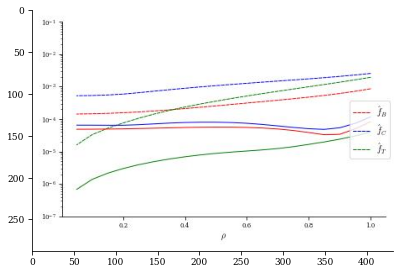

In [ ]:
# target_eq = desc.io.load("./inputs/LandremanPaul2021_QA.h5")
# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     IN_PATH = f"./output/QA/4/pareto/{UUID}/eq.h5"
#     eq = desc.io.load(IN_PATH)
#     fig = plt.figure()
#     ax = fig.add_subplot() 
#     ax.set_ylim(1e-7, 1e-1)
#     desc.plotting.plot_qs_error(eq, ls=["--", "--", "--"], marker=["", "", ""], ax=ax)
#     desc.plotting.plot_qs_error(target_eq, marker=["", "", ""], ax=ax, legend=False)
#     SOURCE_DIR = glob.glob(f"./**/{UUID}/", recursive=True)[0] 
#     EXPORT_PATH = SOURCE_DIR + "qs.jpg"
#     plt.savefig(EXPORT_PATH)
#     plt.close()
#     print(f"Exported UUID {UUID}")

UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    IN_PATH = "./output/QA/4/pareto/"
    img = matplotlib.image.imread(IN_PATH + UUID + "/qs.jpg")
    plt.figure()
    imgplot = plt.imshow(img)

As before, let's create a `.gif`!

In [ ]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')
sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
images = []
for UUID in sorted_pareto['UUID']:
    path = "./output/QA/4/pareto/" + UUID + "/qs.jpg"    
    images.append(imageio.imread(path))
create_movies(images, "pareto_qs", "./output/QA/4/")

![SegmentLocal](./output/QA/4/pareto_qs.gif "segment")

### Fast particle tracing

Let's generate the data first.

In [ ]:
IN_PATH = "./output/QA/4/pareto/"
UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
for UUID in UUIDs:
    if not "confined_fraction.dat" in os.listdir(f"./output/QA/4/pareto/{UUID}/"):
        run_SIMPLE(UUID, trace_time=2e-1, n_test_part=5000, suppress_output=True)
        print(f"Traced {UUID}")

In [ ]:
plot_losses("/Users/sienahurwitz/Documents/Physics/Projects/2023-Force Optimizations/Force Optimizations/output/QA/4/pareto/0a0ef2e8c01743888ced32dd4c0b0c1d/confined_fraction.dat")

### Poincaré Plots

Here, we make Poincare plots of the field.

In [ ]:
for UUID in ['49d67fc2af7e418a95abd1b56613bf03', '13b5e759418c4d29b5b826acc90f5cb9']:
    image = poincare(UUID, OUT_DIR='1/poincare')
    plt.imshow(image)

KeyboardInterrupt: 

### Fast particle tracing

First, we need to scale the equilibria to the minor radius and volume-averaged magnetic field of ARIES-CS.

In [ ]:
# import desc
# import os
# from desc.vmec import VMECIO

# IN_PATH = "./output/QA/4/pareto/"
# UUIDs = [f.name for f in os.scandir(IN_PATH) if f.is_dir()]
# for UUID in UUIDs:
#     eq = desc.io.load(f"./output/QA/4/pareto/{UUID}/eq.h5")
#     eq_scaled = desc.compat.rescale(eq, ('a', 1.7), ('<B>', 5.86))
#     eq_scaled.save(f"./output/QA/4/pareto/{UUID}/eq_scaled.h5")
#     VMECIO.save(eq_scaled, f"./output/QA/4/pareto/{UUID}/eq_scaled.nc", verbose=0)
#     print(f"Saved {UUID}")

## Miscellaneous / Testing
### Ensemble of Optimizations

We can also analyze the success of our optimizations in terms of how and how much data was excluded during the filtering step. These plots show histograms of the optimizations with regard to numerous parameters, plotted both before and after filtering.

In [ ]:
success_plt(df, df_filtered).show()

Let's see what a good `dx` is for the continuation method. Here, we see that $dx\leq 0.1$ seems appropriate.

In [ ]:
df2, df_filtered2, df_pareto2 = get_dfs(INPUT_DIR='./output/QA/3/optimizations/')

fig = plt.figure(figsize=(6.5, 8))
color = 'dx'
markersize = 5
plt.rc("font", size=13)
norm = matplotlib.colors.LogNorm(1e-3, 7e-2)

plt.scatter(
    df_filtered2["normalized_BdotN"],
    df_filtered2["max_max_force"],
    c=df_filtered2[color],
    s=markersize,
    label=f'Continuation Method',
    norm=norm
)
plt.colorbar(label=color)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    marker="+",
    c='black',
    label=f'Original Pareto Front',
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered2["normalized_BdotN"]), max(df_filtered2["normalized_BdotN"]))
plt.ylim(8500, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()